In [60]:
import numpy 
import cv2
import matplotlib.pyplot as plt

# step 1. Interest points detection and feature description
## Read images
img1 = cv2.imread('data/hill1.jpg')
img2 = cv2.imread('data/hill2.jpg') # 2 images we want to stitch
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB) # convert channels BGR to RGB

## Find keypoints and compute desctriptors in 2 images
sift_detector = cv2.xfeatures2d.SIFT_create()
(kp1, desc1) = sift_detector.detectAndCompute(img1,None) # kp is cv2.KeyPoint object
(kp2, desc2) = sift_detector.detectAndCompute(img2,None) # desc is numpy ndarray

In [61]:
# step 2. Feature matching
## the Match provided by openCV
flann = cv2.FlannBasedMatcher()
matches = flann.knnMatch(desc1,desc2,k=2)
good_matchs = []
for (M1,M2) in matches:
    if (M1.distance / M2.distance) < 0.5: # ratio distance
        good_matchs.append([M1.queryIdx, M1.trainIdx])

In [64]:
## Visualize the matching result
### combine 2 images into 1
(h1, w1) = img1.shape[:2]
(h2, w2) = img2.shape[:2]
matching_result = np.zeros((max(h1, h2), w1 + w2, 3), dtype="uint8")
matching_result[0:h1, 0:w1] = img1
matching_result[0:h1, w1:] = img2
### draw the matching lines
for (i, j) in good_matchs:
    c = np.random.randint(0, high=255, size=(3,))
    color = tuple([int(x) for x in c])
    pt1 = (int(kp1[i].pt[0]), int(kp1[i].pt[1]))
    pt2 = (int(kp2[j].pt[0] + w1), int(kp2[j].pt[1]))
    cv2.line(matching_result, pt1, pt2, color, 1)

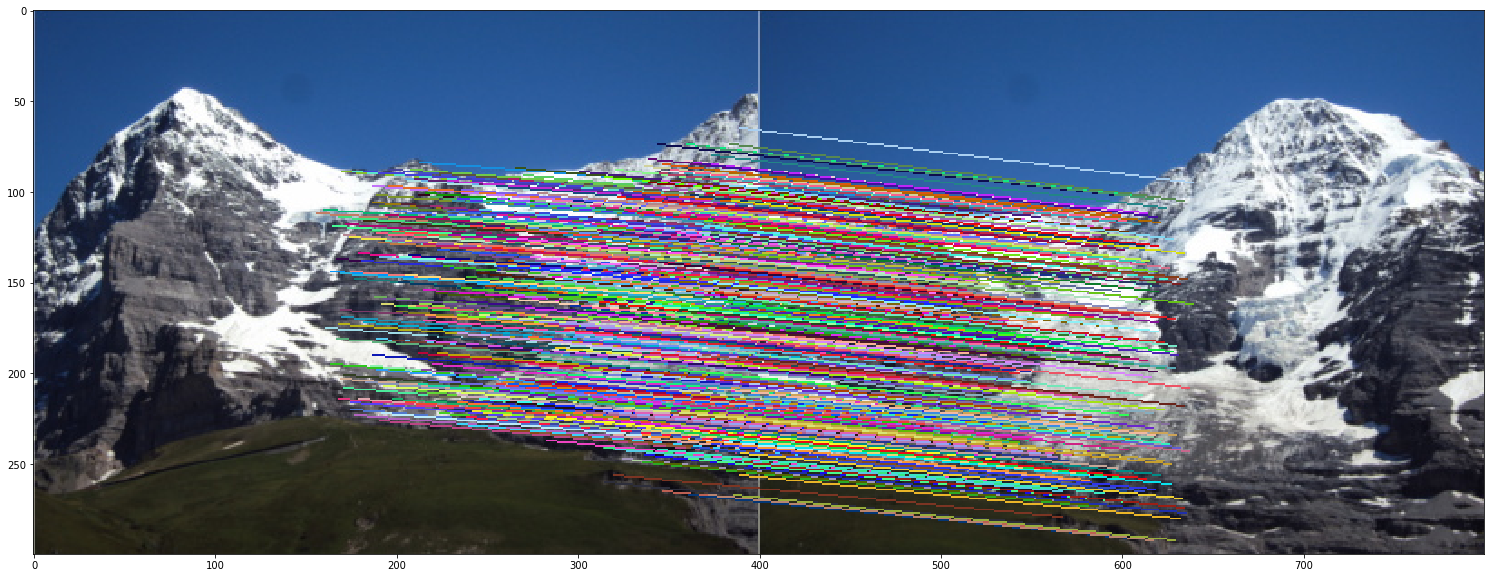

In [65]:
plt.figure(figsize=(26,13))
plt.imshow(matching_result)
plt.show()